# Training with anomaly labels in the datasets

This example presents the model training procedure in presence of anomalies, i.e., unreliable values in the dataset.
The loss function ignores these values, which are said to be masked.

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(""), ".."))

import shutil

import numpy as np
from IPython.display import Markdown as md
import pandas as pd

from torch import nn, optim

from nnbma.networks import FullyConnected
from nnbma.dataset import RegressionDataset, MaskDataset
from nnbma.learning import (
    learning_procedure,
    LearningParameters,
    MaskedMSELoss,
    CauchyLoss,
)

import matplotlib.pyplot as plt

from functions import Fexample as F

plt.rc("text", usetex=shutil.which("latex") is not None)
dpi = 125

## Setup

First, we load and instantiate a vectorial function $f$ implemented as a PyTorch `Module` -- see `functions.py`. 
You can implement your own function by adapting the code.

The function is the following:

In [2]:
f = F()
md(F.latex())

$$\left(\begin{array}{c} t_1\\ t_2 \end{array}\right) \longmapsto \left(\begin{array}{c} t_1+2t_2\\ t_1^2\\ t_1t_2^2 \end{array}\right)$$

Here, we define the **architecture of the neural network** used to approximate the function $f$.  

In [3]:
layers_sizes = [f.n_inputs, 50, 50, f.n_outputs]  # Can be modified
activation = nn.ELU()

net = FullyConnected(layers_sizes, activation)

Then, we generate the **training and test sets with the correct values**.

In [4]:
n_samples = 10_000  # total number of samples
test_frac = 0.20  # proportion of values in the test dataset

np.random.seed(0)  # for reproducibility
X = np.random.normal(0, 1, size=(n_samples, F.n_inputs)).astype("float32")
Y = f(X)

X_train, X_test = X[round(test_frac * n_samples) :], X[: round(test_frac * n_samples)]
Y_train_true, Y_test_true = (
    Y[round(test_frac * n_samples) :],
    Y[: round(test_frac * n_samples)],
)

A fixed proportion of the labels in both datasets is damaged with random values.

In [5]:
p_damage = 0.05  # 5%, can be modified

# Select a fraction p_damage of the labels
mask_train = np.random.rand(*Y_train_true.shape) < p_damage
mask_test = np.random.rand(*Y_test_true.shape) < p_damage

# Add an error of 1 to 5 to a fraction p_damage of the labels
Y_train = np.where(
    mask_train,
    Y_train_true + np.random.randint(5, size=Y_train_true.shape) + 1,
    Y_train_true,
)
Y_test = np.where(
    mask_test,
    Y_test_true + np.random.randint(5, size=Y_test_true.shape) + 1,
    Y_test_true,
)

The resulting training and test sets are converted into `RegressionDataset` objects for compatibility with the `learning_procedure` function. 

In [6]:
train_dataset = RegressionDataset(X_train, Y_train)
test_dataset = RegressionDataset(X_test, Y_test)

train_mask_dataset = MaskDataset(~mask_train)  # Mask is inverted for training
test_mask_dataset = MaskDataset(~mask_test)  # Mask is inverted for training

## Train networks with or without masked labels

First, the training procedure parameters are set.

In [7]:
# Epochs
epochs = 150

# Batch size
batch_size = 250

# Loss function (for non-masked training)
loss_no_mask = nn.MSELoss()

# Loss function (for masked training)
loss_mask = MaskedMSELoss()

# Copies of network in order to perform two different trainings
net_no_mask = net.copy()
net_mask = net.copy()

# Optimizers (for both trainings)
learning_rate = 1e-3
optimizer_no_mask = optim.Adam(net_no_mask.parameters(), learning_rate)
optimizer_mask = optim.Adam(net_mask.parameters(), learning_rate)

We first train a neural network with the dataset with anomalies, i.e., **without masking anomalies**. 
The goal is to show that these anomalies damage the final network accuracy.

In [8]:
learning_params = LearningParameters(
    loss_no_mask, epochs, batch_size, optimizer_no_mask
)

results = learning_procedure(
    net_no_mask,
    (train_dataset, test_dataset),
    learning_params,
    val_frac=test_frac,
)

# Compute outputs for both training and testing sets
Y_train_hat = net_no_mask(X_train)
Y_test_hat = net_no_mask(X_test)

Epoch: 100%|██████████| 150/150 [00:21<00:00,  6.98it/s, train loss=0.505, val loss=0.546, train error=67107.86%, val error=87064.32%]                      

Second, we train a neural network with the dataset with **masked anomalies**. 
In this example, the true masked is used to demonstrate improvement in the final network accuracy.
In practice, the true mask is unknown.

In [9]:
learning_params = LearningParameters(loss_mask, epochs, batch_size, optimizer_mask)

results = learning_procedure(
    net_mask,
    (train_dataset, test_dataset),
    learning_params,
    mask_dataset=(train_mask_dataset, test_mask_dataset),
    val_frac=test_frac,
)

# Compute outputs for both training and testing sets
Y_train_hat_mask = net_mask(X_train)
Y_test_hat_mask = net_mask(X_test)

Epoch: 100%|██████████| 150/150 [00:29<00:00,  5.05it/s, train loss=0.000901, val loss=0.00361, train error=9.77%, val error=204.93%]                        

**Comparison between labels estimation**

In [10]:
def metric(y_hat: np.ndarray, y: np.ndarray, reduce: bool = True):
    if reduce:
        return np.mean((y_hat - y) ** 2)  # overall average
    return (y_hat - y) ** 2  # elementwise

On the **training set** (on the first output):

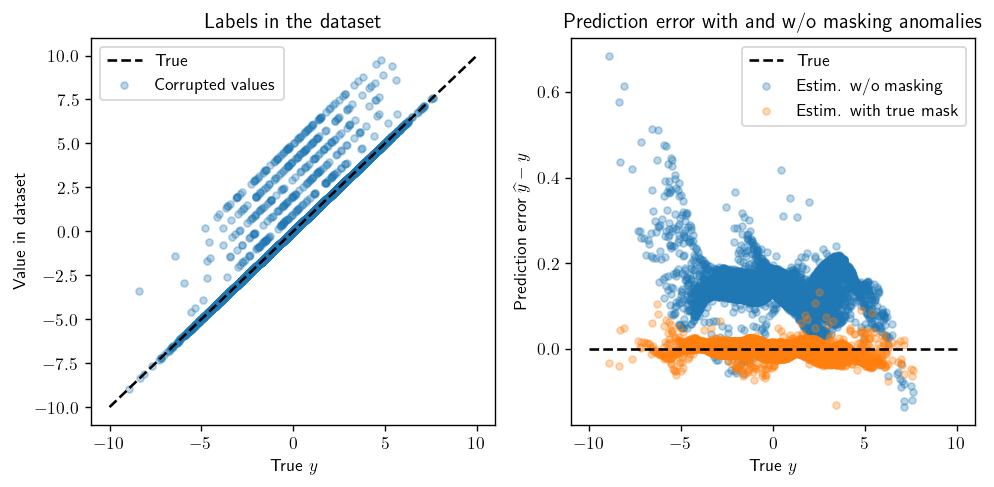

In [11]:
df1 = pd.DataFrame()
df1["True"] = Y_train_true[:, 0]
df1["corrup"] = Y_train[:, 0]
df1["estim. w/o masking"] = Y_train_hat[:, 0]
df1["estim. with true mask"] = Y_train_hat_mask[:, 0]

df1["error w/o masking"] = df1["estim. w/o masking"] - df1["True"]
df1["error with true mask"] = df1["estim. with true mask"] - df1["True"]

#

plt.figure(figsize=(8, 4), dpi=dpi)

plt.subplot(1, 2, 1)

plt.plot([-10, 10], [-10, 10], "k--", label="True")
plt.scatter(df1["True"], df1["corrup"], s=16, label="Corrupted values", alpha=0.3)

plt.xlabel(r"True $y$")
plt.ylabel(r"Value in dataset")
plt.title("Labels in the dataset")
plt.legend()

plt.subplot(1, 2, 2)

plt.plot([-10, 10], [0, 0], "k--", label="True")
plt.scatter(
    df1["True"], df1["error w/o masking"], s=16, label="Estim. w/o masking", alpha=0.3
)
plt.scatter(
    df1["True"],
    df1["error with true mask"],
    s=16,
    label="Estim. with true mask",
    alpha=0.3,
)

plt.xlabel(r"True $y$")
plt.ylabel(r"Prediction error $\widehat{y} - y$")
plt.title("Prediction error with and w/o masking anomalies")
plt.legend()

plt.tight_layout()
plt.show()

On the **test set** (on the first output):

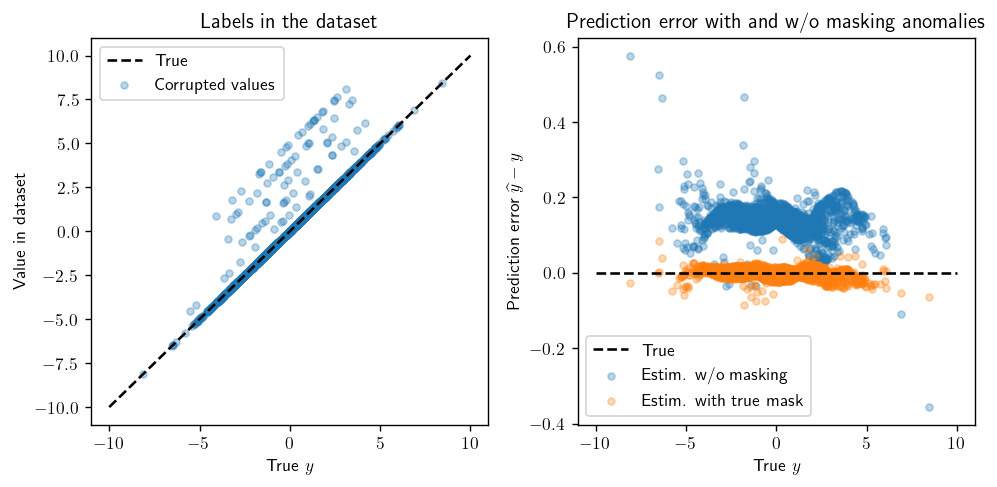

In [12]:
df2 = pd.DataFrame()
df2["True"] = Y_test_true[:, 0]
df2["corrup"] = Y_test[:, 0]
df2["estim. w/o masking"] = Y_test_hat[:, 0]
df2["estim. with true mask"] = Y_test_hat_mask[:, 0]

df2["error w/o masking"] = df2["estim. w/o masking"] - df2["True"]
df2["error with true mask"] = df2["estim. with true mask"] - df2["True"]

#

plt.figure(figsize=(8, 4), dpi=dpi)

plt.subplot(1, 2, 1)

plt.plot([-10, 10], [-10, 10], "k--", label="True")
plt.scatter(df2["True"], df2["corrup"], s=16, label="Corrupted values", alpha=0.3)

plt.xlabel(r"True $y$")
plt.ylabel(r"Value in dataset")
plt.title("Labels in the dataset")
plt.legend()

plt.subplot(1, 2, 2)

plt.plot([-10, 10], [0, 0], "k--", label="True")
plt.scatter(
    df2["True"], df2["error w/o masking"], s=16, label="Estim. w/o masking", alpha=0.3
)
plt.scatter(
    df2["True"],
    df2["error with true mask"],
    s=16,
    label="Estim. with true mask",
    alpha=0.3,
)

plt.xlabel(r"True $y$")
plt.ylabel(r"Prediction error $\widehat{y} - y$")
plt.title("Prediction error with and w/o masking anomalies")
plt.legend()

plt.tight_layout()
plt.show()

## Detecting anomalies in 2 steps

### Step 1. Use a robust loss function to detect outliers: the Cauchy loss.

In [13]:
net_robust = net.copy()

# Robust loss function (that is likely to ignore outliers)
loss_robust = CauchyLoss()

# Optimizer
optimizer_robust = optim.Adam(net_robust.parameters(), learning_rate)

Train the new network:

In [14]:
learning_params = LearningParameters(loss_robust, epochs, batch_size, optimizer_robust)

results = learning_procedure(
    net_robust,
    (train_dataset, test_dataset),
    learning_params,
    val_frac=test_frac,
)

# Compute outputs for both training and testing sets
Y_train_hat_robust = net_robust(X_train)
Y_test_hat_robust = net_robust(X_test)

# Compute errors
errors_train = metric(Y_train_hat_robust, Y_train, reduce=False)
errors_test = metric(Y_test_hat_robust, Y_test, reduce=False)

Epoch: 100%|██████████| 150/150 [00:22<00:00,  6.65it/s, train loss=0.103, val loss=0.105, train error=102194.09%, val error=124657.45%]                       

In [15]:
df1["estim. robust to anomalies"] = Y_train_hat_robust[:, 0]
df1["error robust to anomalies"] = df1["estim. robust to anomalies"] - df1["True"]

df2["estim. robust to anomalies"] = Y_test_hat_robust[:, 0]
df2["error robust to anomalies"] = df2["estim. robust to anomalies"] - df2["True"]

**Detection of outliers**: 
For the example, we will consider that we already know the proportion of anomalies in the dataset. 
If it wasn't the case, we could have use other methods to automatically or manually segment the samples in two categories (reliable and anomalies). 
Here, we just consider the first `100*p_damage` % of errors as anomalies.

In [16]:
mask_train_estimated = errors_train > np.quantile(errors_train, 1 - p_damage)
mask_test_estimated = errors_test > np.quantile(errors_test, 1 - p_damage)

#
print("Train set")
print(
    f"Proportion of anomalies well detected: {100*np.mean(mask_train_estimated & mask_train):.1f}% (true total: 5%)"
)
print(
    f"Fraction of false alarms: {100*np.mean(mask_train_estimated & ~mask_train):.1f}%"
)

print("\nTest set")
print(
    f"Proportion of anomalies well detected: {100*np.mean(mask_test_estimated & mask_test):.1f}% (true total: 5%)"
)
print(f"Fraction of false alarms: {100*np.mean(mask_test_estimated & ~mask_test):.1f}%")

Train set
Proportion of anomalies well detected: 4.9% (true total: 5%)
Fraction of false alarms: 0.1%

Test set
Proportion of anomalies well detected: 4.7% (true total: 5%)
Fraction of false alarms: 0.3%


In this basic case, this simple procedure identifies most anomalies. 

### Step 2. Train a network with a masked non-robust loss function

In [17]:
train_mask_estimated_dataset = MaskDataset(
    ~mask_train_estimated
)  # Mask is inverted for training
test_mask_estimated_dataset = MaskDataset(
    ~mask_test_estimated
)  # Mask is inverted for training

In [18]:
net_mask_2 = net.copy()

# Non-robust masked loss function
loss_mask_2 = MaskedMSELoss()

# Optimizer
optimizer_mask_2 = optim.Adam(net_mask_2.parameters(), learning_rate)

In [19]:
learning_params = LearningParameters(loss_mask_2, epochs, batch_size, optimizer_mask_2)

results = learning_procedure(
    net_mask_2,
    (train_dataset, test_dataset),
    learning_params,
    mask_dataset=(train_mask_estimated_dataset, test_mask_estimated_dataset),
    val_frac=test_frac,
)

Epoch: 100%|██████████| 150/150 [00:30<00:00,  4.88it/s, train loss=0.000523, val loss=0.00045, train error=8.63%, val error=8.58%]         

Evaluation of the resulting network:

In [20]:
# Compute outputs for both training and testing sets
Y_train_hat_mask_2 = net_mask_2(X_train)
Y_test_hat_mask_2 = net_mask_2(X_test)

df1["estim. learnt mask"] = Y_train_hat_mask_2[:, 0]
df1["error learnt mask"] = df1["estim. learnt mask"] - df1["True"]

df2["estim. learnt mask"] = Y_test_hat_mask_2[:, 0]
df2["error learnt mask"] = df2["estim. learnt mask"] - df2["True"]

And we finally compare the MSE of each of the networks:

In [21]:
list_cols = [
    "error w/o masking",
    "error robust to anomalies",
    "error learnt mask",
    "error with true mask",
]

print("Train set:")
print((df1[list_cols] ** 2).mean())

print("\nTest set:")
print((df2[list_cols] ** 2).mean())

Train set:
error w/o masking            0.021183
error robust to anomalies    0.000972
error learnt mask            0.000103
error with true mask         0.000185
dtype: float32

Test set:
error w/o masking            0.020946
error robust to anomalies    0.001002
error learnt mask            0.000126
error with true mask         0.000187
dtype: float32


__Observations:__

- When no masked is used, the anomalies considerably damage the obtained MSE.
- On the example, the network robust to outliers divides the MSE, typically by a factor of a few hundred. It permits defining a mask on the training and test sets.
- The neural network trained with the masked MSE further divides the MSE, generally by a factor ~ 2.
- Lower errors are generally achieved with the true mask, although this may not always be the case.